In [ ]:
# In this notebook, I remove outliers, interpolate abnormal absorbance points and remove noisy wavelengths.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyexcel.cookbook import merge_all_to_a_book
from matplotlib.cbook import boxplot_stats
import glob

plt.rcParams["figure.figsize"]=20,10
plt.rcParams.update({'font.size': 28})
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot(data):
    fig, ax = plt.subplots()
    if data.ndim == 1:
        a = plt.plot(data)
    else:
        a = plt.plot(data.columns, data.T)
    
#     plt.xticks([])
    plt.title('Absorbance x Wavelength')
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')

In [91]:
df = pd.read_csv('../data/final/firmness_final.csv')

In [163]:
df = pd.read_csv('../data/final/sst_final.csv')

In [170]:
df = pd.read_csv('../data/final/drymass_final.csv')

In [ ]:
# ATTENTION!!!! THERE ARE MISSING ABSORBANCE DATA IN THE .*_final.csv files. I'll ignore it for now.

In [183]:
df.dropna().reset_index(inplace=True, drop=True)

In [184]:
df.shape

(830, 310)

In [185]:
abs_data = df[df.columns[4:]].copy()

In [186]:
qua_data = df[df.columns[:4]].copy()

# selecting non-noisy wavelengths

In [187]:
abs_data = abs_data.loc[:,'435':'1110']

# treating outliers

In [188]:
outliers = abs_data[abs_data.values > 50]
outliers = outliers.append(abs_data[abs_data.values < -50])

/home/danielesreis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/danielesreis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


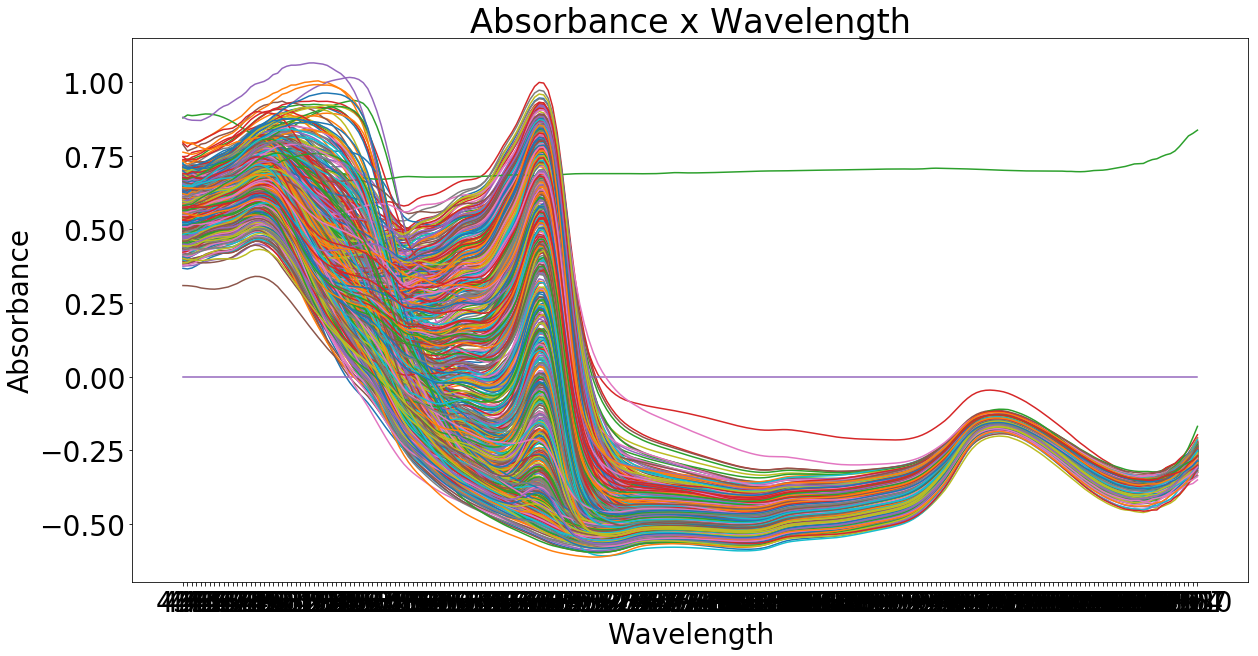

In [178]:
plot(abs_data.drop(outliers.index))

In [87]:
# we can notice that there's a sample which all absorbances are equal to 0 and that there's another one
# with an different behavior and shifted in the y-axis

In [ ]:
# removing sample with std = 0

In [179]:
arr = abs_data.std(axis=1)

In [180]:
arr[arr == 0]

234    0.0
dtype: float64

In [181]:
abs_data.drop(234, inplace=True)
qua_data.drop(234, inplace=True)

abs_data.reset_index(inplace=True, drop=True)
qua_data.reset_index(inplace=True, drop=True)

In [132]:
# removing sample with ununsual behavior

In [133]:
arr = abs_data.drop(outliers.index).std(axis=1)

In [134]:
arr[arr < 0.1]

559    0.052204
dtype: float64

In [135]:
abs_data.drop(561, inplace=True)
qua_data.drop(561, inplace=True)

abs_data.reset_index(inplace=True, drop=True)
qua_data.reset_index(inplace=True, drop=True)

In [189]:
new_abs = abs_data.drop(outliers.index).drop([234,562])
new_qua = qua_data.drop(outliers.index).drop([234,562])

In [108]:
# getting outliers again because abs_data was reseted

In [190]:
outliers = abs_data[abs_data.values > 50]
outliers = outliers.append(abs_data[abs_data.values < -50])

/home/danielesreis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/danielesreis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [191]:
outliers_per_sample = outliers.apply(lambda x: boxplot_stats(x)[0]['fliers'], axis=1)

# for some reason there are duplicated samples
unique_outliers = outliers_per_sample[~outliers_per_sample.index.duplicated(keep='first')]

In [192]:
# make outliers equal to NaN
nan_abs_data = abs_data.iloc[unique_outliers.index.values]\
.apply(lambda series: series
       .map(lambda value: np.NaN if value in unique_outliers[series.name] else value), axis=1)

In [144]:
abs_data.iloc[nan_abs_data.index] = nan_abs_data

In [193]:
new_abs.iloc[nan_abs_data.index] = nan_abs_data

In [194]:
new_abs.shape

(812, 226)

In [ ]:
# for sst (temporary)

In [145]:
new_abs.drop(548, inplace=True)
new_abs.reset_index(inplace=True, drop=True)

new_qua.drop(548, inplace=True)
new_qua.reset_index(inplace=True, drop=True)

In [146]:
new_abs.drop(547, inplace=True)
new_abs.reset_index(inplace=True, drop=True)

new_qua.drop(547, inplace=True)
new_qua.reset_index(inplace=True, drop=True)

# interpolating linearly

In [145]:
abs_data.interpolate(limit=10, inplace=True)

In [196]:
new_abs.interpolate(limit=10, inplace=True)

In [ ]:
# there is still a weird sample outlier (sample 234)

In [55]:
abs_data.iloc[234][['498','510','534','555','576','588','606','615','636','693','696','801','825',\
                    '834','837','948','963','1026',
                    '1056','1062','1077']] = np.nan

In [56]:
abs_data.interpolate(limit=10, inplace=True)

In [ ]:
# new df

In [36]:
treated = pd.concat([qua_data,abs_data], sort=False, axis=1)

In [199]:
treated = pd.concat([new_qua,new_abs], sort=False, axis=1)

In [ ]:
# raw data with nan values

In [84]:
treated.to_csv('../data/final/nan_data.csv')

In [200]:
treated.to_csv('../data/final/nan_drymass_data.csv')

# removing samples that contains nan values

In [231]:
atts = qua_data.columns[3:].values
dic = {'color': ['L', 'C', 'H'], 'fresh mass': 'FRESH MASS', 'firmness': 'FIRMNESS', \
       'color_p': ['LP', 'CP', 'HP'], 'sst': 'SST', 'acidity': 'TOTAL ACIDITY', 'dry mass': 'DRY MASS'}

In [233]:
for att in dic.keys():
    if type(dic[att]) == list:
        var = meta + dic[att] + wvls
    else:
        var = meta + [dic[att]] + wvls
        
    treated[var].dropna().reset_index(drop=True).to_csv('../data/final/abs_%s.csv' % att)

In [ ]:
# changing dot to comma, so I can send it to the others

In [238]:
def func (value):
    value = str(value).replace('.', ',')
    if value == 'nan':
        value = np.nan
    return value

In [239]:
formatted = treated.applymap(func)

In [240]:
for att in dic.keys():
    if type(dic[att]) == list:
        var = meta + dic[att] + wvls
    else:
        var = meta + [dic[att]] + wvls
        
    formatted[var].dropna().reset_index(drop=True).to_csv('../data/final/xlsx/abs_%s.csv' % att)

In [191]:
meta = list(qua_data.columns[:3].values)